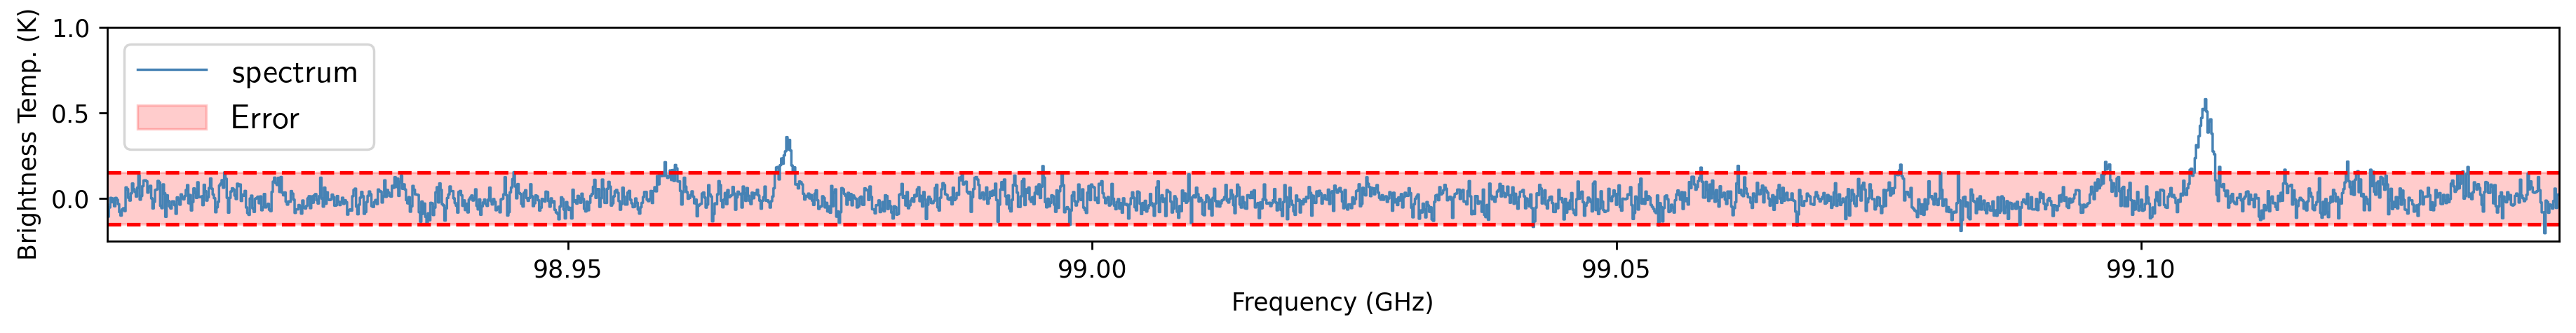

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt    
from astropy.wcs import WCS                 
from astropy import units as u  
import pylab
import regions
import numpy as np
from spectral_cube import SpectralCube
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
#Takes pixel position in Cont --> pixel position in new cube
path="B.Dust_Ridge_sci.spw25_27_29_31.cont.I.tt0.pbcor.fits"
header=fits.getheader(path)
w1=WCS(header)
w1 = w1.dropaxis(3)
w1 = w1.dropaxis(2)
#finds the pixel positions for the RA and dec
#find RA DEC of x,y,z
core_coords=w1.pixel_to_world(166,175)
#reads in file
path="A.Dust_Ridge_sci.spw31.cube.I.pbcor.fits"
#find the corresponding pixel positions for those coords in new image
header=fits.getheader(path)
w1=WCS(header)
image_coords=core_coords.to_pixel(w1,0,mode="wcs")
#makes figure
fig1=pylab.figure(1,figsize=(15,2),dpi=250)
#plots spectrum
sc=SpectralCube.read(path)
sc.allow_huge_operations=True 
sc_Ghz=sc.with_spectral_unit(u.GHz)
sc_Ghz=sc_Ghz.to(u.K)
freq,Dec,Ra = sc_Ghz.world[:,0,0]

regpix = regions.CirclePixelRegion(regions.PixCoord(image_coords[0],image_coords[1]), radius=8)  
subcube = sc_Ghz.subcube_from_regions([regpix])  
spectrum = subcube.mean(axis=(1, 2))
plt.plot(freq,spectrum,lw=1,drawstyle='steps-mid',color="SteelBlue",label="spectrum")
pylab.xlabel("Frequency (GHz)", fontsize=10) 
pylab.ylabel('Brightness Temp. (K)',fontsize=10)
plt.rcParams['text.usetex'] = True

###Noise Calculations###
#range
Noise_upper=825
Noise_lower=800
sigma=np.std(spectrum[Noise_lower:Noise_upper].value)
three_sigma=3*sigma
pylab.hlines(three_sigma,freq[0].value,freq[1915].value,colors="red",label ='',ls="--" )
pylab.hlines(-three_sigma,freq[0].value,freq[1915].value,colors="red",label ='',ls="--" )
pylab.xlim(freq[0].value,freq[1915].value)
plt.fill_between(freq.value,three_sigma, -three_sigma, alpha = 0.2, color= 'red',label='Error' )

plt.legend(fontsize=14,loc="upper left")
pylab.ylim(-0.25,1)
plt.tight_layout()
plt.savefig("A.spw31.pdf")
plt.savefig("A.spw31.png")
plt.show()

# Line ID

Param #0   AMPLITUDE0 =     0.716654 +/-       0.0264675 
Param #1       SHIFT0 =       99.106 +/-     3.10128e-05 
Param #2       WIDTH0 =  0.000727222 +/-     3.10127e-05   Range:   [0,inf)


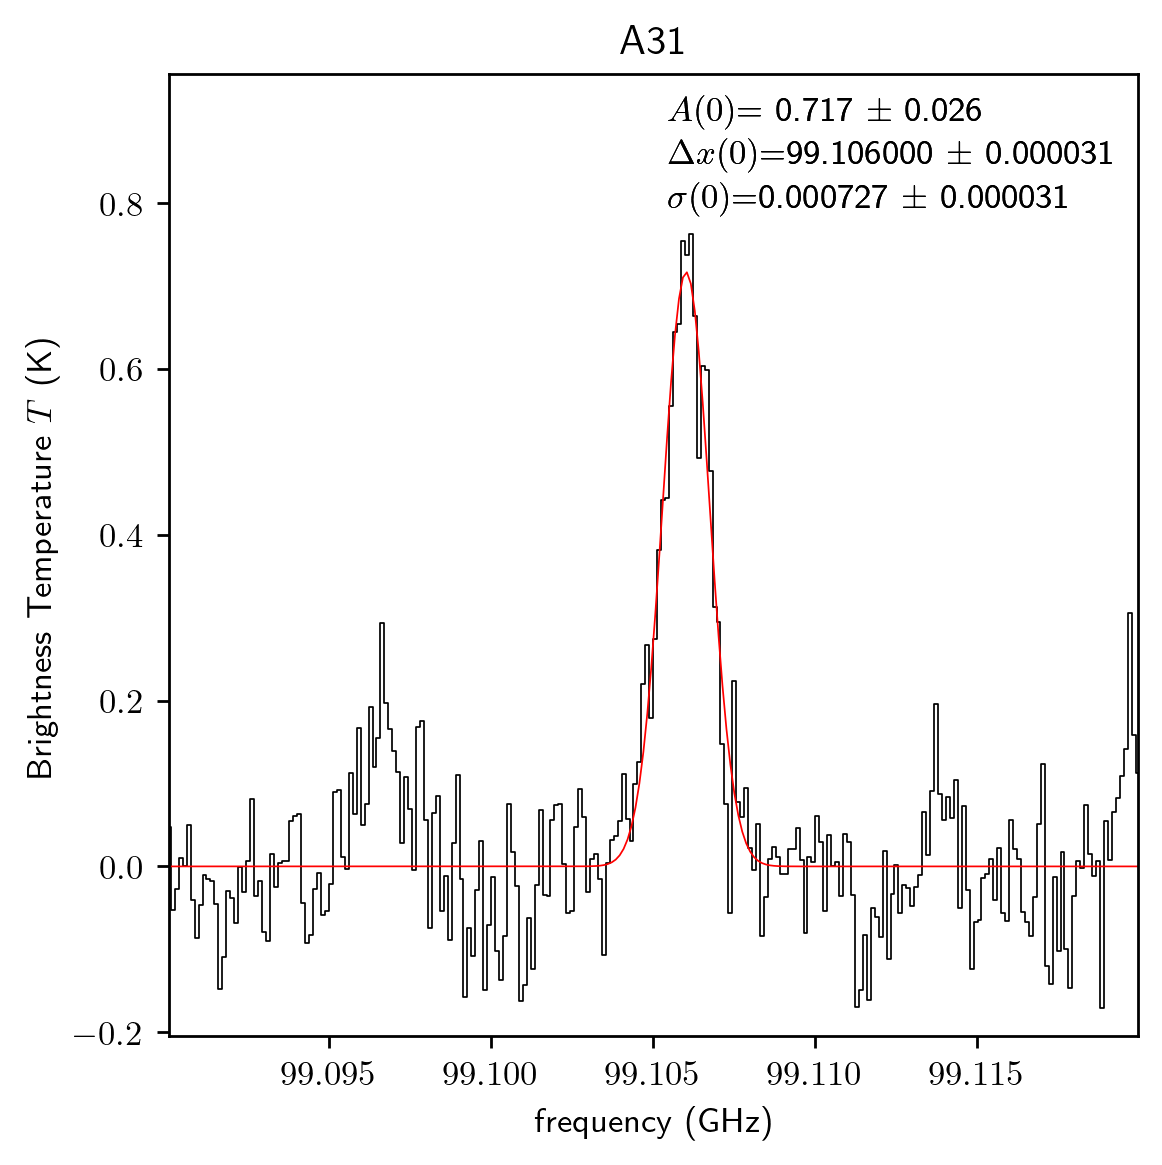

In [3]:
#Creates regions zoomed around feature
zoom = np.where((freq.value>99.09)*(freq.value<99.12))
zoom_spectrum=spectrum[zoom]
zoom_freq = freq[zoom]

#Calculates the error 
error = np.zeros(np.size(zoom))
meas = sigma #uses sigma calc from previous block
error = error + meas

#plots the gaussian fit
sp = pyspeckit.Spectrum(data=zoom_spectrum,xarr=zoom_freq,error=error,unit='K')
fig1 = pylab.figure(1,figsize=(5,5),dpi=250)
sp.plotter(axis=pylab.subplot(1,1,1),title="A31")
sp.specfit(fittype='gaussian')
sp.plotter.savefig('A.spw31.brightest.pdf')
sp.plotter.savefig('A.spw31.brightest.png')
print(sp.specfit.parinfo)